In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('GBTree').getOrCreate()

In [2]:
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler, Imputer
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
df = spark.read.csv('../data_processed/mp_data_24hr.csv', header = True, inferSchema = True)
df = df.withColumnRenamed("hospital_expire_flag", "label")

In [4]:
# df.printSchema()
from collections import defaultdict
data_types = defaultdict(list)
for field in df.schema.fields:
    data_types[str(field.dataType)].append(field.name)
for key in data_types.keys():
    print(key, len(data_types[key]))

IntegerType 24
StringType 4
DoubleType 103


Category Indexing, One-Hot Encoding, Imputer, and VectorAssembler - a feature transformer that merges multiple columns into a vector column.

The code below indexes each categorical column using the StringIndexer, then converts the indexed categories into one-hot encoded variables. The resulting output has the binary vectors appended to the end of each row. VectorAssembler combines all the feature columns into a single vector column.

In [5]:
stages = []

# categorical features
categoricalColumns = ['ethnicity','gender','admission_type']

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index').setHandleInvalid("keep") # keep unseen labels
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

# numerical features    
numericCols = ['age', 'icustay_num',
               'heartrate_mean', 'sysbp_mean', 'diasbp_mean', 'meanbp_mean',
               'resprate_mean', 'tempc_mean', 'spo2_mean', 'glucose_mean', 
               'heartrate_min', 'sysbp_min', 'diasbp_min','meanbp_min', 
               'resprate_min', 'tempc_min', 'spo2_min', 'glucose_min',
               'heartrate_max', 'sysbp_max', 'diasbp_max', 'meanbp_max',
               'resprate_max', 'tempc_max', 'spo2_max', 'glucose_max', 
               'gcs_mean', 'gcsmotor_mean', 'gcsverbal_mean', 'gcseyes_mean', 'endotrachflag_mean',
               'gcs_min', 'gcsmotor_min', 'gcsverbal_min', 'gcseyes_min', 'endotrachflag_min', 
               'gcs_max', 'gcsmotor_max', 'gcsverbal_max', 'gcseyes_max', 'endotrachflag_max', 
               'baseexcess_mean', 'carboxyhemoglobin_mean', 'methemoglobin_mean', 
               'po2_mean', 'pco2_mean', 'ph_mean', 'pao2fio2ratio_mean', 'totalco2_mean', 
               'aniongap_mean', 'albumin_mean', 'bands_mean', 'bicarbonate_mean', 
               'bilirubin_mean', 'calcium_mean', 'creatinine_mean', 'chloride_mean', 
               'hematocrit_mean', 'hemoglobin_mean', 'lactate_mean', 'platelet_mean', 
               'potassium_mean', 'ptt_mean', 'inr_mean', 'sodium_mean', 'bun_mean', 'wbc_mean',
               'baseexcess_min', 'carboxyhemoglobin_min', 'methemoglobin_min',
               'po2_min', 'pco2_min', 'ph_min', 'pao2fio2ratio_min', 'totalco2_min',
               'aniongap_min', 'albumin_min', 'bands_min', 'bicarbonate_min',
               'bilirubin_min', 'calcium_min', 'creatinine_min', 'chloride_min',
               'hematocrit_min', 'hemoglobin_min', 'lactate_min', 'platelet_min',
               'potassium_min', 'ptt_min', 'inr_min', 'sodium_min', 'bun_min', 'wbc_min', 
               'baseexcess_max', 'carboxyhemoglobin_max', 'methemoglobin_max', 
               'po2_max', 'pco2_max', 'ph_max', 'pao2fio2ratio_max', 'totalco2_max',          
               'aniongap_max', 'albumin_max', 'bands_max', 'bicarbonate_max', 
               'bilirubin_max', 'calcium_max', 'creatinine_max', 'chloride_max', 
               'hematocrit_max', 'hemoglobin_max', 'lactate_max', 'platelet_max', 
               'potassium_max', 'ptt_max', 'inr_max', 'sodium_max', 'bun_max', 'wbc_max', 
               'urineoutput']

imputer = Imputer(strategy='median', inputCols=numericCols, outputCols=['imputed_' + col for col in numericCols])
stages += [imputer]

# assemble
assemblerInputs = [c + "classVec" for c in categoricalColumns] + ['imputed_' + col for col in numericCols]
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [6]:
# categorical columns fill na
df = df.fillna('missing', subset=categoricalColumns)
# cast integer columns to double datatype for the imputer
for col in numericCols:
    if col in data_types['IntegerType']:
        df = df.withColumn(col, df[col].cast('double'))
# check
data_types = defaultdict(list)
for field in df.schema.fields:
    data_types[str(field.dataType)].append(field.name)
for key in data_types.keys():
    print(key, len(data_types[key]))

IntegerType 5
StringType 4
DoubleType 122


In [7]:
train, test = df.randomSplit([0.8, 0.2], seed = 0)

Use Pipeline to chain multiple Transformers and Estimators together to specify our machine learning workflow. A Pipeline’s stages are specified as an ordered array.

In [8]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(train)
train = pipelineModel.transform(train)
test = pipelineModel.transform(test)

In [9]:
selectedCols = ['label', 'features']
train = train.select(selectedCols)
test = test.select(selectedCols)
train.printSchema()

root
 |-- label: integer (nullable = true)
 |-- features: vector (nullable = true)



### Gradient-boosted Tree Classifier

In [10]:
gbt = GBTClassifier(featuresCol = 'features', labelCol = 'label', maxIter=10, seed=0)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.select('rawPrediction', 'prediction', 'probability').show(5)

+--------------------+----------+--------------------+
|       rawPrediction|prediction|         probability|
+--------------------+----------+--------------------+
|[-0.9572764035626...|       1.0|[0.12847023138874...|
|[1.20082617098612...|       0.0|[0.91695321609176...|
|[0.62617834106363...|       0.0|[0.77770754751751...|
|[1.11227174253371...|       0.0|[0.90243197488551...|
|[1.02779021105879...|       0.0|[0.88651027603981...|
+--------------------+----------+--------------------+
only showing top 5 rows



In [11]:
evaluator = BinaryClassificationEvaluator()
auc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
print("Test Area Under ROC: " + str(auc))

Test Area Under ROC: 0.8293142966764953


Try to tune Gradient Boosting Tree model with the ParamGridBuilder and the CrossValidator. Before that we can use explainParams() to print a list of all params and their definitions to understand what params available for tuning.

In [16]:
print(gbt.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

In [17]:
# grid trial #1
# paramGrid = (ParamGridBuilder()
#              .addGrid(gbt.maxIter, [20, 50])
#              .addGrid(gbt.maxDepth, [3, 5, 10])
#              .addGrid(gbt.minInstancesPerNode, [3])
#              .addGrid(gbt.subsamplingRate, [1, 0.8])
#              .build())

# grid trial #2
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxIter, [100, 250])
             .addGrid(gbt.stepSize, [0.1, 0.03, 0.01])
             .addGrid(gbt.maxDepth, [5, 10])
             .addGrid(gbt.minInstancesPerNode, [3])
             .build())

cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

In [18]:
cv

CrossValidator_62dba5da50f2

In [19]:
# Run cross validations.
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
auc = evaluator.evaluate(predictions)

In [20]:
bestModel = cvModel.bestModel
bestParams = bestModel.extractParamMap()
print('Best Param (maxIter): ', bestModel._java_obj.getMaxIter())
print('Best Param (stepSize): ', bestModel._java_obj.getStepSize())
print('Best Param (maxDepth): ', bestModel._java_obj.getMaxDepth())
print('Best Param (minInstancesPerNode): ', bestModel._java_obj.getMinInstancesPerNode())

Best Param (maxIter):  250
Best Param (stepSize):  0.1
Best Param (maxDepth):  5
Best Param (minInstancesPerNode):  3


Best Param (maxIter):  50

Best Param (maxDepth):  5

Best Param (minInstancesPerNode):  3

Best Param (subsamplingRate):  1.0

AUC: 0.8620531632896719

### Plot AUC curve

In [21]:
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        for row in rdd.collect():
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

In [22]:
preds = predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
# Returns as a list (false positive rate, true positive rate)
points = CurveMetrics(preds).get_curve('roc')

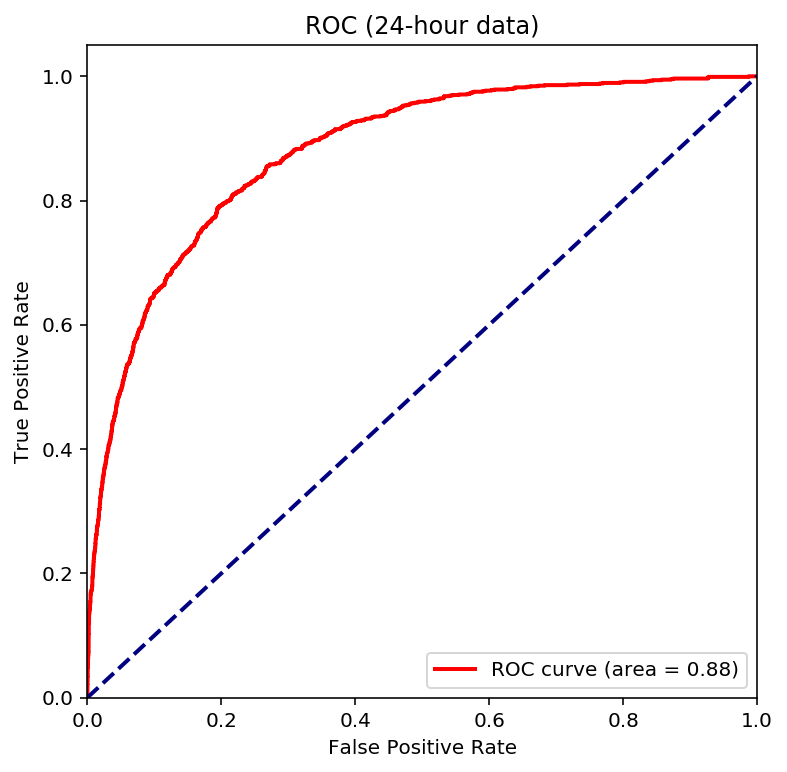

In [23]:
auc = evaluator.evaluate(predictions)
fig = plt.figure(figsize=(6,6))

lw = 2
plt.plot([x[0] for x in points],[x[1] for x in points], color='red', lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (24-hour data)')
plt.legend(loc="lower right")

fig.savefig('../img/GBT_%0.4f.png'% auc)
plt.show()
